<a href="https://colab.research.google.com/github/jihosuperman/Bigquery-google-analytics-data/blob/main/google_analytics_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL | EDA of Bigquery Google Analytics Data

source : https://www.kaggle.com/code/dillonmyrick/sql-eda-of-bigquery-google-analytics-data

## Goal

The goal of this project is to act as Web Analyst for the Google Merchandise Store, and analyze Google Analytics data from Bigquery using SQL. The period for this analysis will be 2016/08/01 ~ 2017/08/01.

Site :  https://shop.googlemerchandisestore.com/

For this analysis we'll focus on 3 main goals:

- Understand the composition of current site traffic
- Understand the flow and conversion path of users
- Forcast product demand

In addtion, we'll use following steps as a framework to organize our anaysis :

1. Extract data and confirm structure/contents
2. Make our goals more concrete
3. Explore and analyze data
4. Visualize insights and interpret results

In [41]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import pprint

%matplotlib inline

## 1. Extract Data and Confirm Structure/Contents
First, let's connect to Bigquery and see what kind of data we'll be working with and how it's structured.

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import glob

key_path = glob.glob("./drive/MyDrive/google-analytics/google-cloud-key/*.json")[0]

credentials = service_account.Credentials.from_service_account_file(key_path)

# Create client object
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Create dataset reference
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")

# Retrieve dataset from reference
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.

In [3]:
# View tables in dataset
[x.table_id for x in client.list_tables(dataset)][:5]

['ga_sessions_20160801',
 'ga_sessions_20160802',
 'ga_sessions_20160803',
 'ga_sessions_20160804',
 'ga_sessions_20160805']

In [4]:
# Create table reference

table_ref_20160801 = dataset_ref.table('ga_sessions_20160801')

# Retrieve table from reference
table_20160801 = client.get_table(table_ref_20160801)

# View columns
client.list_rows(table_20160801, max_results=5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,<NA>,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,<NA>,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged
2,<NA>,3,1470078988,1470078988,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6440789996634275026,None,Organic Search,Not Socially Engaged
3,<NA>,4,1470075581,1470075581,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 19, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",8520115029387302083,None,Referral,Not Socially Engaged
4,<NA>,30,1470099026,1470099026,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...",6792260745822342947,None,Organic Search,Not Socially Engaged


It looks like the totals, trafficSource, device, geoNetwork, customDimensions, and hits columns contain nested data.</br>
Lets check the schema for these columns and asee what kind of data they contain.

In [47]:
client.list_rows(table_20160801, max_results=5).to_dataframe().iloc[0, 5]

{'visits': 1,
 'hits': 24,
 'pageviews': 17,
 'timeOnSite': 287,
 'bounces': None,
 'transactions': None,
 'transactionRevenue': None,
 'newVisits': 1,
 'screenviews': None,
 'uniqueScreenviews': None,
 'timeOnScreen': None,
 'totalTransactionRevenue': None,
 'sessionQualityDim': None}

In [45]:
table_20160801.schema[5]

SchemaField('totals', 'RECORD', 'NULLABLE', None, None, (SchemaField('visits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('hits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('pageviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('timeOnSite', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('bounces', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('transactions', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('transactionRevenue', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('newVisits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('screenviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('uniqueScreenviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('timeOnScreen', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('totalTransactionRevenue', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('sessionQualityDim', 'INTEGER', 'NULLABLE', None,

In [57]:
# Display schemas
print("SCHEMA field and Sample for the 'totals' columns:")
print(table_20160801.schema[5],'\n')

print("SCHEMA field for the 'trafficSource' columns:")
print(table_20160801.schema[6],'\n')

print("SCHEMA field for the 'device' columns:")
print(table_20160801.schema[7],'\n')

print("SCHEMA field for the 'geoNetwork' columns:")
print(table_20160801.schema[8],'\n')

print("SCHEMA field for the 'customDimension' columns:")
print(table_20160801.schema[9],'\n')

print("SCHEMA field for the 'hits' columns:")
print(table_20160801.schema[10],'\n')

SCHEMA field and Sample for the 'totals' columns:
SchemaField('totals', 'RECORD', 'NULLABLE', None, None, (SchemaField('visits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('hits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('pageviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('timeOnSite', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('bounces', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('transactions', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('transactionRevenue', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('newVisits', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('screenviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('uniqueScreenviews', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('timeOnScreen', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('totalTransactionRevenue', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField

After checking the schema, we can see that hits column contains page view, transaction, product, Google Ads, and other data.</br></br>
The full data dictionary can be found here : https://support.google.com/analytics/answer/3437719?hl=en

## 2. Make Our Goals Concrete

After confirming the content and structure of the data that we'll be working with, we can now define our goals in more detail.

- Analyze which pages are the most popular, as wekk as their bounce/exit rates
- Examine number of sessions by browser and device
- Explore the type and quality of site traffic
- Identify the customer conversion path and any potential bottlenecks
- Identify the best-selling product categories forecast their demand

## 3. Explore and Analyze Data

### Most Popular Pages

First, let's look at the most frequently visited landing pages and their respective bounce rates.
</br></br>
The bounce rate is the number of bounces(sessions where the user entered the site and then immediately left) devided by the total number of sessions.
</br></br>
A high bounce rate can indicate either:
1. Users are not seeing what they expected when they enter the site, Search Engine Optimization (SEO) needs to be done
2. There is a functionality or display issue with the landing page

In [6]:
# [hitNumber =1] Indicates the first hit of session

query = """
        SELECT
            hits.page.pagePath AS landing_page,
            COUNT(*) AS views,
            SUM(totals.bounces)/COUNT(*) AS bounce_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) as hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            hits.type='PAGE'
            AND
            hits.hitNumber=1
        GROUP BY landing_page
        ORDER BY views DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
result.head(10)

,landing_page,views,bounce_rate
0,/home,612140,0.495475
1,/google+redesign/shop+by+brand/youtube,81512,0.562347
2,/google+redesign/apparel/men++s/men++s+t+shirts,20685,0.441141
3,/signin.html,16296,0.361622
4,/google+redesign/apparel/mens/mens+t+shirts,12691,0.475061
5,/basket.html,9431,0.454565
6,/google+redesign/drinkware,8833,0.533794
7,/google+redesign/bags,8608,0.451208
8,/google+redesign/apparel/men++s/men++s+outerwear,6345,0.432782
9,/google+redesign/apparel,6326,0.448150


Looking at the bounce rates, It looks like Men's Apparel and Bags are comparatively lower than other pages.</br>
We can also see that the YouTube and Drinkware pages have a lot of views, but have a high bounce rate, indicating either a problem with the page's funtionality, or users not seeing what they were expecting to when they entered the site.</br></br>
Let's take a look at the exit rate next.</br>
The exit rate is similar to the bounce rate, except that it is calculated for all pages and not just landing pages. It is the number of exits (sessions where the user navigated to a page and then exited the site) divided by the total number of sessions.

A high exit rate can indicate either:
1. Users are not seeing whay they expect when they navigate to a page
2. There is a functionality or display issue with page

In [7]:
query = """
        SELECT
            hits.page.pagePath AS page,
            COUNT(*) AS views,
            SUM(totals.bounces)/COUNT(*) AS exit_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            hits.type='PAGE'
        GROUP BY page
        ORDER BY views DESC
        """

result = client.query(query).result().to_dataframe()
result.head(20)

,page,views,exit_rate
0,/home,981285,0.309920
1,/basket.html,209360,0.020524
2,/google+redesign/shop+by+brand/youtube,145026,0.316198
3,/signin.html,101299,0.058322
4,/store.html,93551,0.025505
5,/google+redesign/apparel/men++s/men++s+t+shirts,67471,0.135392
6,/asearch.html,62380,0.031677
7,/google+redesign/electronics,56839,0.047116
8,/google+redesign/apparel,56552,0.050272
9,/google+redesign/bags,53686,0.072458


Compared with other pages, exit rates for pages related to Men's Apparel are slightly high, and the exit rate for YouTube is very high.

### Browser and Device

Next, Let's look at sessions by browser and device to see if there are any compatibility issues.

In [8]:
query = """
        SELECT
            device.Browser As browser,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY browser
        ORDER BY sessions DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
result.head(10)

,browser,sessions,exit_rate
0,Chrome,3197849,0.091878
1,Safari,629906,0.157622
2,Firefox,133880,0.168195
3,Internet Explorer,62405,0.190369
4,Edge,38063,0.150934
5,Android Webview,25979,0.174872
6,Safari (in-app),19037,0.213532
7,Opera,15439,0.209988
8,Opera Mini,12767,0.314639
9,UC Browser,5807,0.283968


Among the top 5 browsers, the exit rate for Chrome is comparatively low at 9%, while the other browsers are roughly 7~8% higher with the exception of Internet Explorer, having an exit rate of 19%.</br></br></br>
Let's check the devices.

In [9]:
query = """
        SELECT
            device.deviceCategory AS device,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY device
        ORDER BY sessions DESC
        """

result = client.query(query).result().to_dataframe()
result.head(10)

,device,sessions,exit_rate
0,desktop,3171344,0.104038
1,mobile,838327,0.130486
2,tablet,144004,0.105907


Looking at the exit rates, we can see that Mobile is about 2.5% higher than other devices. It's possible that the site is not optimized for mobile viewing.

### Traffic Type and Quality
Now let's examine session and transaction data for each source of traffic to our site.

In [10]:
query = """
        SELECT
            trafficSource.medium As medium,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totalTransactionRevenue)/1000000 AS total_revenue,
            SUM(totals.transactions)/COUNT(*) AS conversion_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY medium
        ORDER BY sessions DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
result.head(10)

,medium,sessions,exit_rate,transactions,total_revenue,conversion_rate
0,(none),2246040,0.069684,363228,69842914.68,0.161719
1,organic,1141113,0.101857,97332,19504702.25,0.085296
2,referral,580309,0.285806,22040,3501224.27,0.037980
3,cpc,88591,0.055028,9457,1528330.72,0.106749
4,affiliate,55860,0.157698,334,29118.69,0.005979
5,cpm,41253,0.054372,5951,8676307.66,0.144256
6,(not set),509,0.108055,17,203.83,0.033399


It looks like most traffic is either Organic or Referral.</br></br>
We can also see that the conversion rate for CPC and CPM is quite high compared to other sources.</br></br>
Here the conversion rate refers to the percentage of sessions that resulted in a transaction being completed.

### Identify Conversion Path and Possible Bottlenecks
Next, we will identify the customer's conversion path through the site, as well as areas in the conversion process where users are leaving the site

In [11]:
# Aggregate hits by action type

query = """
        SELECT
            CASE WHEN hits.eCommerceAction.action_type = '1' THEN 'Click through of product lists'
                    WHEN hits.eCommerceAction.action_type = '2' THEN 'Product detail views'
                    WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                    WHEN hits.eCommerceAction.action_type = '6' THEN 'Completed purchase'
            END AS action,
            COUNT(fullVisitorID) AS users
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            (
            hits.eCommerceAction.action_type != '0'
            AND
            hits.eCommerceAction.action_type != '3'
            AND
            hits.eCommerceAction.action_type != '4'
            )
        GROUP BY action
        ORDER BY users DESC
        """

result = client.query(query).result().to_dataframe()
result.head(10)

,action,users
0,Click through of product lists,445760
1,Product detail views,362607
2,Check out,248936
3,Completed purchase,74457


In [12]:
# Create funnel graph
fig = go.Figure(go.Funnel(y = result['action'], x = result['users'], textposition = 'inside', textinfo = 'value+percent initial'))
fig.update_layout(title_text = 'Google Merchandise Store Conversion Path')
fig.show()

69% of users who viewed the product details proceeded to the check out page.</br>
We can see however that of those users, only 30% actually complete a purchase

### Identify Best-Selling Product Categories and Forcast Demand

Now that we understand what the conversion path is for visitors to the site, let's see what product categories are the most popular.

In [13]:
query = """
        SELECT
            product.v2ProductCategory AS category,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totalTransactionRevenue)/1000000 AS total_revenue
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY category
        ORDER BY total_revenue DESC
        LIMIT 10
        """

cat_result = client.query(query).result().to_dataframe()
cat_result.head(10)

,category,transactions,total_revenue
0,(not set),155239,51801830.97
1,Apparel,133504,44923859.06
2,Home/Apparel/Men's/Men's-T-Shirts/,147131,25222312.08
3,Home/Office/,100994,20222511.87
4,Home/Electronics/,62603,13716689.08
5,Office,41837,12733564.97
6,Home/Apparel/,61127,11863650.76
7,Home/Apparel/Women's/Women's-T-Shirts/,58134,11448008.84
8,Home/Drinkware/Water Bottles and Tumblers/,44300,10600034.98
9,Home/Apparel/Men's/,77731,9781940.51


Several of the best-selling categories are related to Apparel with Men's-T-Shirts being near the top. We can also see that Office, Electronics, and Water Bottles and Tumblers are selling well.</br></br>
In order to forecast demand for Men's T-Shirts, the best-selling product in Apparel category, let's calculate the 7-day moving average for transactions.

<Axes: title={'center': "Men's T-shirts Weekly Moving Average"}, xlabel='date'>

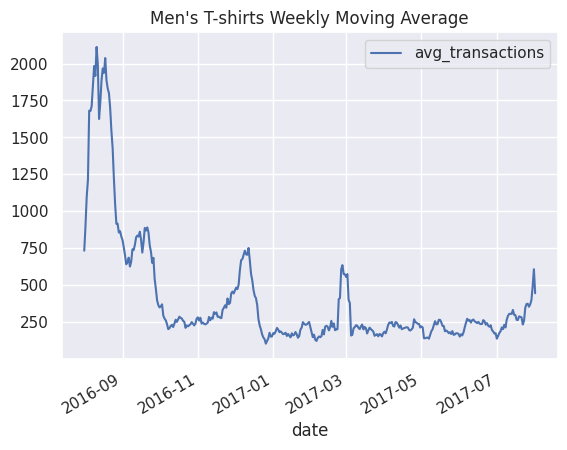

In [14]:
query = """
        WITH daily_mens_tshirt_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Apparel/Men's/Men's-T-Shirts/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM daily_mens_tshirt_transactions
        """

result = client.query(query).result().to_dataframe()
result['date'] = pd.to_datetime(result['date'])
result.plot(y='avg_transactions', x='date', kind='line', title="Men's T-shirts Weekly Moving Average")

Looking at the chart above, it would seem there is some seasonality in the demand for Men's T-Shirts.</br>
Let's look at the moving average for Office and Water Bottles and Tumblers as well and see if there is a similar trend.

<Axes: title={'center': 'Drinkware Weekly Moving Average'}, xlabel='date'>

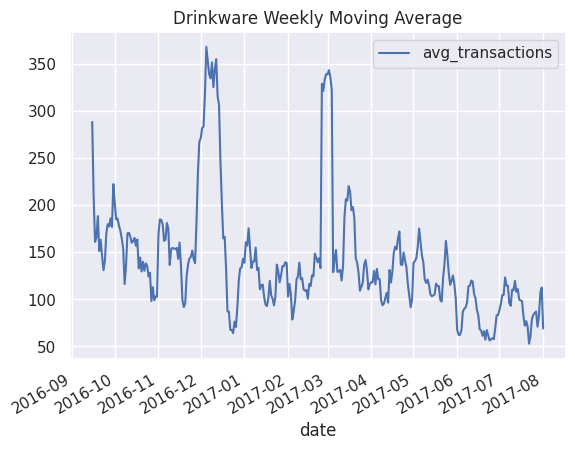

In [15]:
query = """
        WITH daily_drinkware_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Drinkware/Water Bottles and Tumblers/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_drinkware_transactions
        """

result = client.query(query).result().to_dataframe()
result['date'] = pd.to_datetime(result['date'])
result.plot(y='avg_transactions', x='date', kind='line', title='Drinkware Weekly Moving Average')

<Axes: title={'center': 'Electronics Weekly Moving Average'}, xlabel='date'>

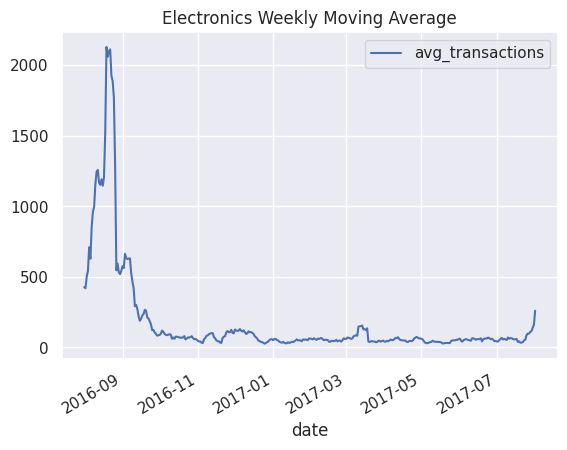

In [22]:
query = """
        WITH daily_electronics_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Electronics/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER(
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_electronics_transactions
        """

result = client.query(query).result().to_dataframe()
result['date'] = pd.to_datetime(result['date'])
result.plot(y='avg_transactions', x='date', kind='line', title='Electronics Weekly Moving Average')

<Axes: title={'center': 'Office Weekly Moving Average'}, xlabel='date'>

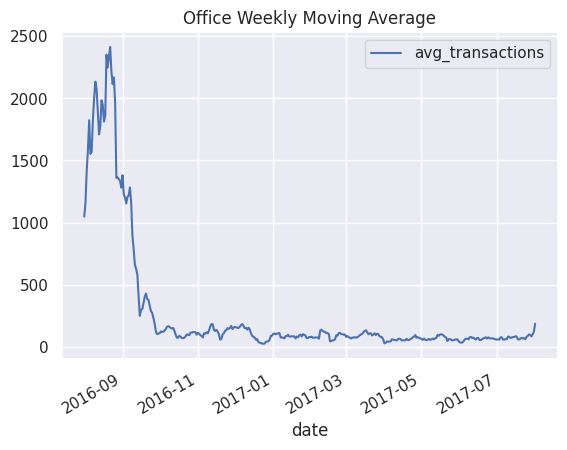

In [23]:
query = """
        WITH daily_office_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Office/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_office_transactions
        """

result = client.query(query).result().to_dataframe()
result['date'] = pd.to_datetime(result['date'])
result.plot(y='avg_transactions', x='date', kind='line', title='Office Weekly Moving Average')

The average transactions for August 2016 are very high compared to later periods, but since we don't know the cause of this we will ignore it for now.</br></br>
Office and Electronics products seems to have steady demand year-round, Drinkware seems to see a spike in demand in December and March, and demand for Men's T-Shirts seems to increase in September, March, and August.

## 4. Visualize Insights and Interpret Results

### Most Popular Landing Pages and Bounce Rates
The followings are the most visited landing pages and their respective bounce rates:

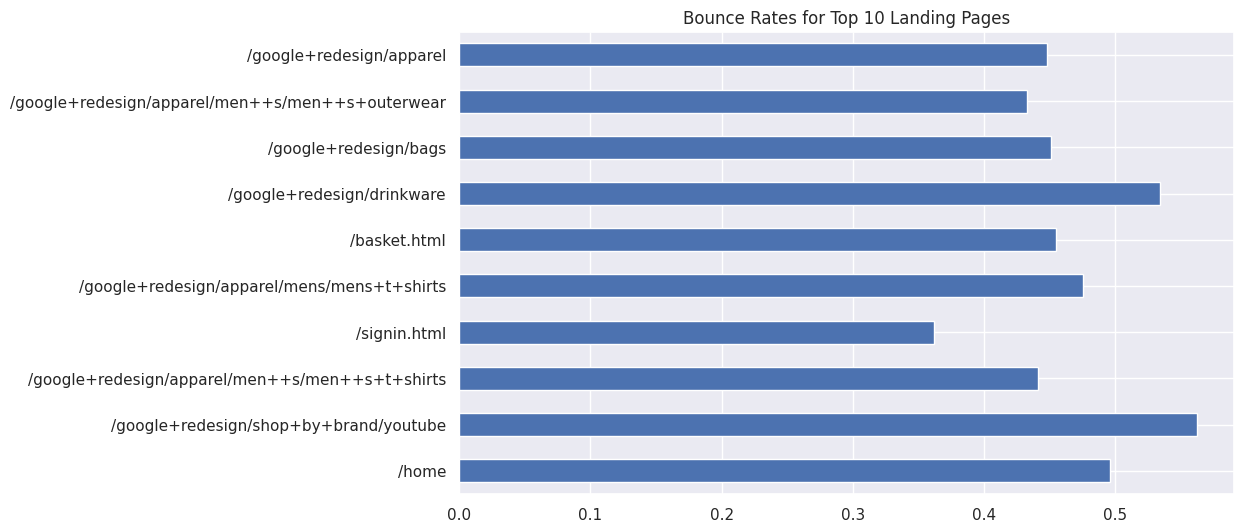

In [24]:
query = """
        SELECT
            hits.page.pagePath AS landing_page,
            COUNT(*) AS views,
            SUM(totals.bounces)/COUNT(*) AS bounce_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            hits.type='PAGE'
            AND
            hits.hitNumber=1
        GROUP BY landing_page
        ORDER BY views DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
fig, ax = plt.subplots(figsize=(10,6))
result.plot(y=['bounce_rate'], x='landing_page', kind='barh', legend=False, title='Bounce Rates for Top 10 Landing Pages', ax=ax)
ax.set_ylabel('')

plt.show()

From this I have formulated the following hypotheses:

1. The reason that YouTube is the second most visited landing page and yet has the highest bounce rate is that there are a large number of visitors looking for YouTuber merchandise, and not YouTube brand merchandise.
2. The reason for login and Basket's high visits and low bounce rate is due to a large number of repeat visitors.
3. Within the top 10 landing pages 3 are related to Men's Apparel, indicating it is an especially popular category

With these ideas in mind, let's look at browsers and devices next.

### Browser and Device

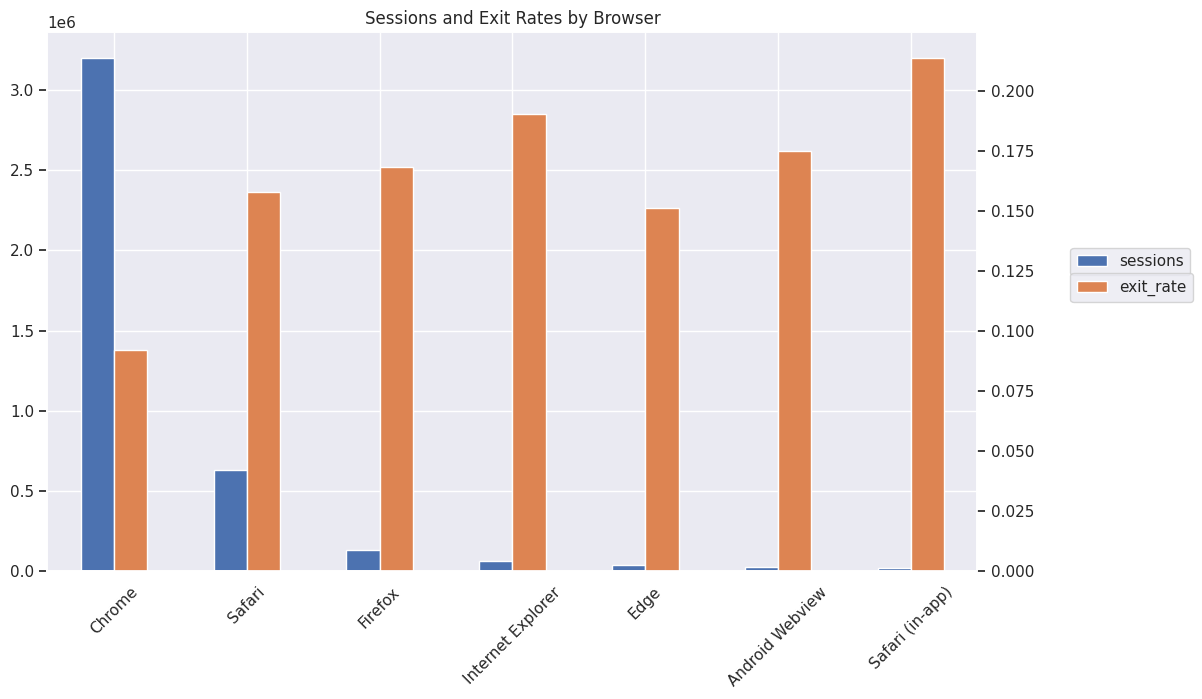

In [32]:
query = """
        SELECT
            device.Browser AS browser,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY browser
        ORDER BY sessions DESC
        LIMIT 7
        """

result = client.query(query).result().to_dataframe()
fig, ax = plt.subplots(figsize=(12,7))
result.plot(y=['sessions', 'exit_rate'], x='browser', kind='bar', secondary_y='exit_rate', ax=ax, mark_right=False, title='Sessions and Exit Rates by Browser')
ax.set_xticklabels(labels=result['browser'], rotation=45)
ax.set_xlabel('')
ax.legend(loc=(1.1, 0.55))
plt.legend(loc=(1.1, 0.5))

plt.show()

The majority of sessions are from Chrome, but there are a significant number of sessions from Safari and Firefox as well.</br>
The exit rate for Safari and Firefox is significantly higher than Chrome, which could indicate compatibility issues.

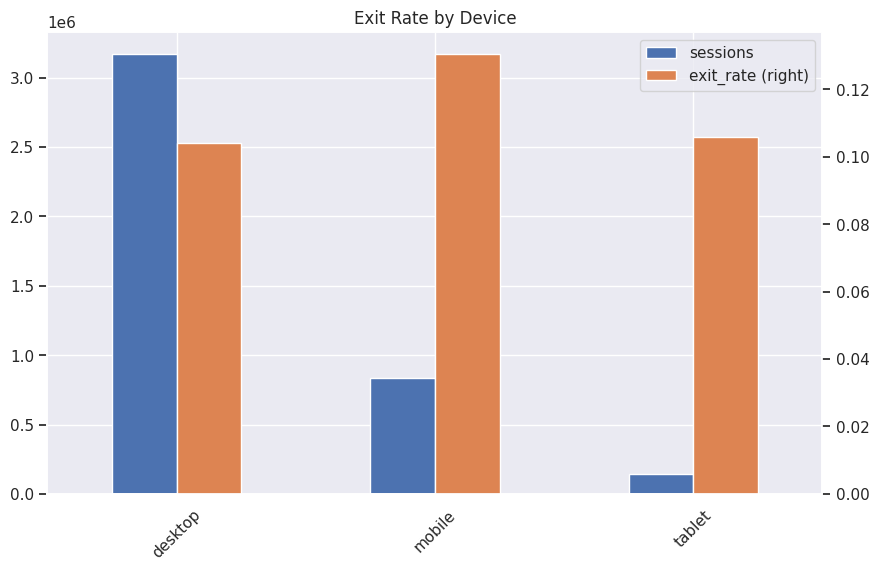

In [33]:
query = """
        SELECT
            device.deviceCategory AS device,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY device
        ORDER BY sessions DESC
        """

result = client.query(query).result().to_dataframe()
fig, ax = plt.subplots(figsize=(10,6))
result.plot(y=['sessions', 'exit_rate'], x='device', kind='bar', title='Exit Rate by Device', secondary_y='exit_rate', ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(labels=result['device'], rotation=45)
plt.show()

Here we see that the majority of sessions are on desktop, with a significant number also coming from mobile.</br>
We can also see the roughlt 2.5% greater exit rate of mobile compared to desktop and tablet.</br>
This likely due to :

1. The site not being optimized for mobile devices
2. Users first browsing product pages on their mobile devices, and then later returning on desktop to complete their purchase

It may therefore be useful to conduct a user test for mobile devices.</br>
With this we can understand where users may face problems not just on browser and device level, but on a page, form, and even button level.

### Type and Quality of Traffic

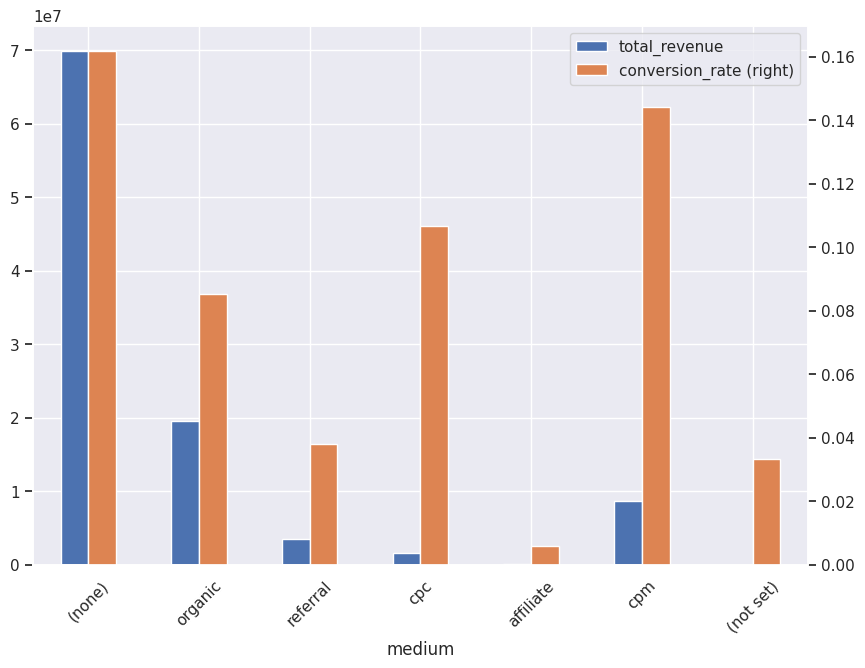

In [35]:
query = """
        SELECT
            trafficSource.medium AS medium,
            COUNT(*) AS sessions,
            SUM(totals.bounces)/COUNT(*) AS exit_rate,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totalTransactionRevenue)/1000000 AS total_revenue,
            SUM(totals.transactions)/COUNT(*) AS conversion_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY medium
        ORDER BY sessions DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
fig, ax = plt.subplots(figsize=(10,7))
result.plot(y=['total_revenue', 'conversion_rate'], x='medium', kind='bar', secondary_y='conversion_rate', ax=ax)
ax.set_xticklabels(labels=result['medium'], rotation=45)
plt.show()

Most of our traffic is organic, followed by CPM, referral, and CPC.</br>
However, our paid advertising sources, CPM and CPC, have a noticeably higher conversion rate in comparision to the other sources.

### Identify Best-Selling Product Categories and Forecast Demand

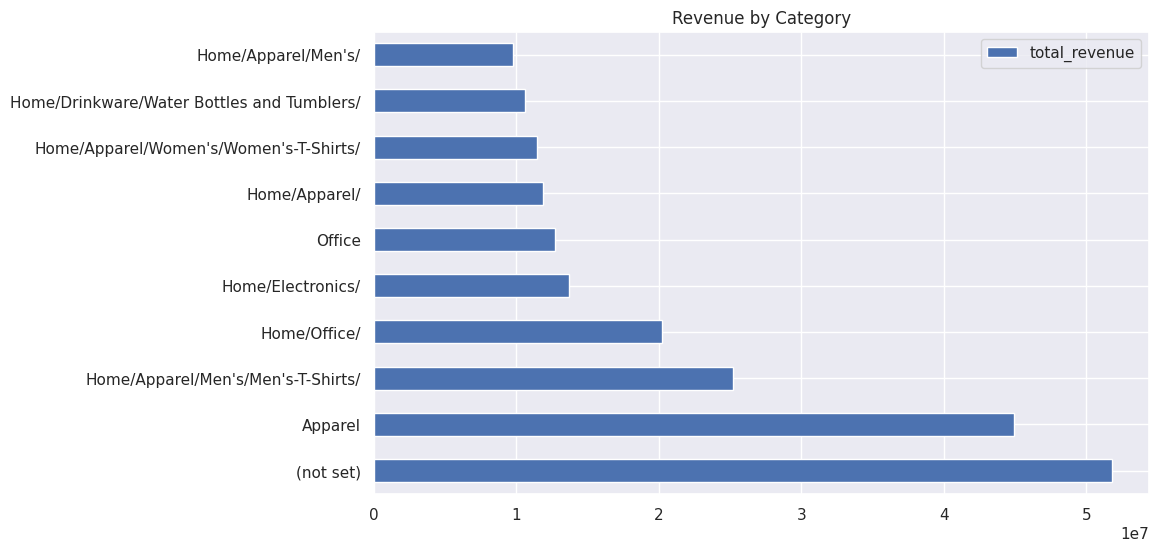

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
cat_result.plot(y='total_revenue', x='category', kind='barh', title='Revenue by Category', ax=ax)
ax.set_ylabel('')
plt.show()

The best-selling categories are Apparel, Office, Electronics, Office, and Drinkware.</br>
Within the Apparel category, Men's T-Shirts seems to sell sepecially well.</br>
Let's look at the moving average of transactions for Men's T-shirts, Drinkware, Office, and Electronics to see if their is any seasonal demand.

<Axes: title={'center': 'Electronics Weekly Moving Average'}, xlabel='date'>

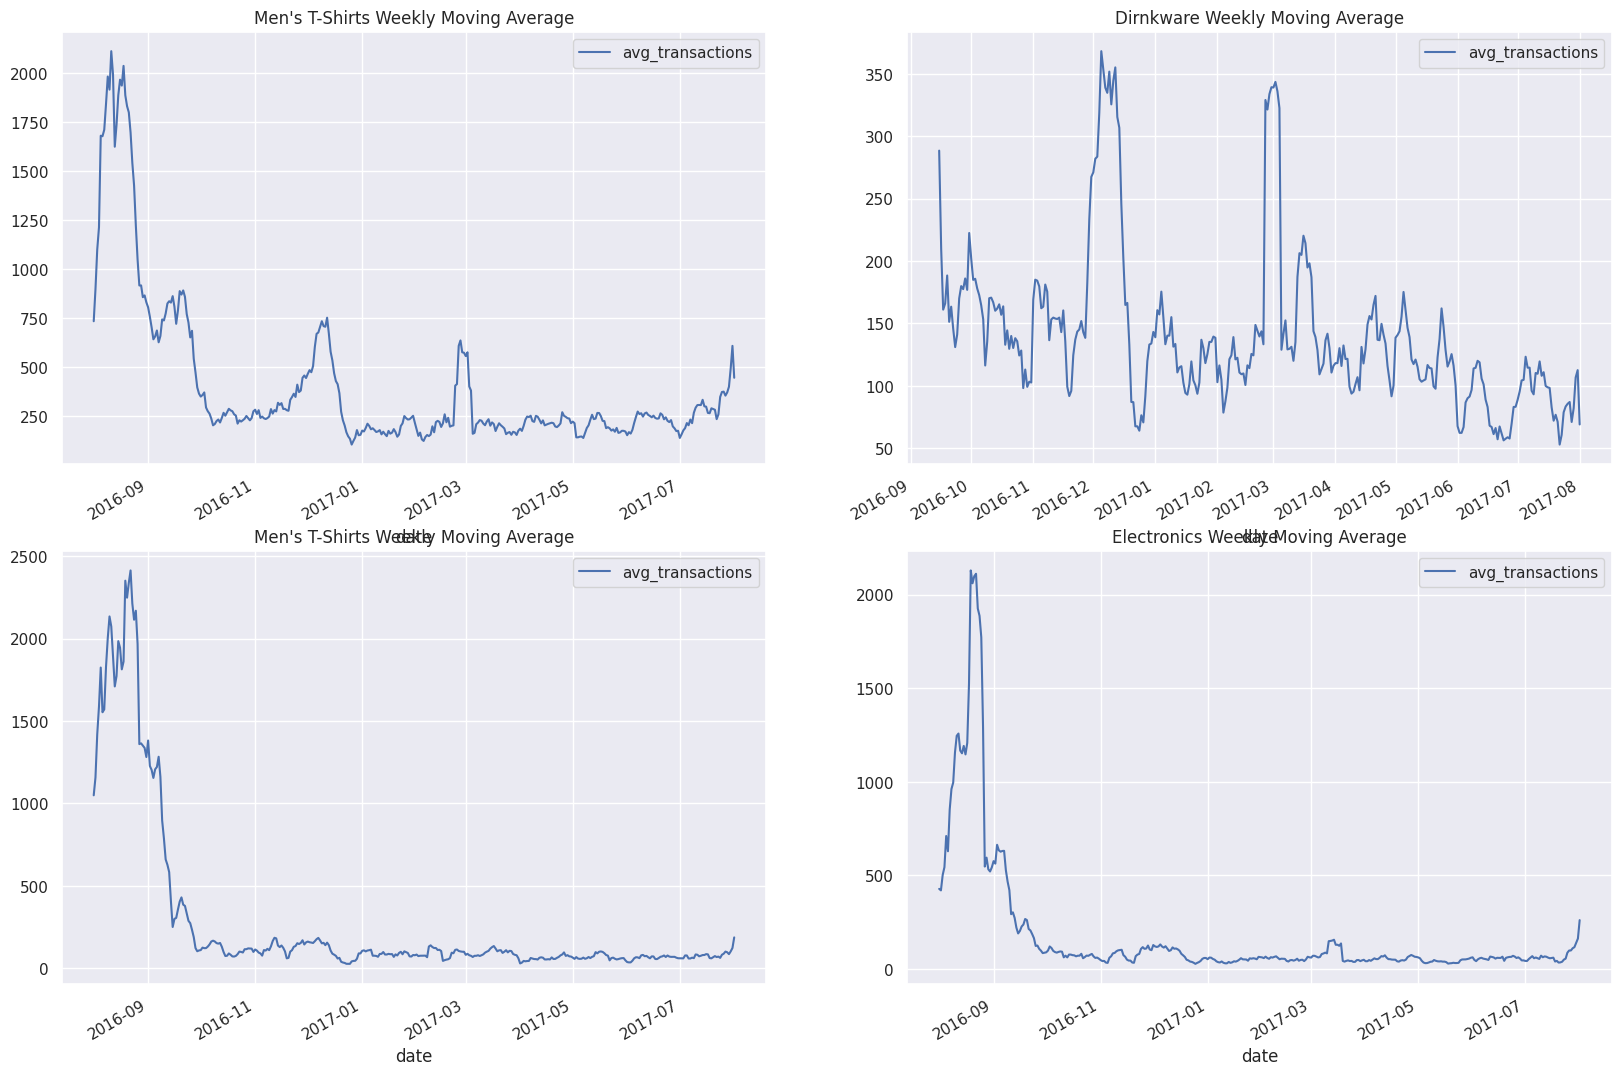

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))

# Men's T-shirts
query1 = """
        WITH daily_mens_tshirt_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Apparel/Men's/Men's-T-Shirts/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_mens_tshirt_transactions
        """

result1 = client.query(query1).result().to_dataframe()
result1['date'] = pd.to_datetime(result1['date'])
ax1 = result1.plot(y='avg_transactions', x='date', kind='line', title="Men's T-Shirts Weekly Moving Average", ax=axes[0,0])

# Drinkware
query2 = """
        WITH daily_drinkware_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Drinkware/Water Bottles and Tumblers/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_drinkware_transactions
        """

result2 = client.query(query2).result().to_dataframe()
result2['date'] = pd.to_datetime(result2['date'])
result2.plot(y='avg_transactions', x='date', kind='line', title="Dirnkware Weekly Moving Average", ax=axes[0,1])

# Office Supplies
query3 = """
        WITH daily_office_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Office/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_office_transactions
        """

result3 = client.query(query3).result().to_dataframe()
result3['date'] = pd.to_datetime(result3['date'])
result3.plot(y='avg_transactions', x='date', kind='line', title="Men's T-Shirts Weekly Moving Average", ax=axes[1,0])

# Electronics
query4 = """
        WITH daily_electronics_transactions AS
        (
        SELECT
            date,
            SUM(totals.transactions) AS transactions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            AND
            product.v2ProductCategory = "Home/Electronics/"
        GROUP BY date
        ORDER BY date
        )
        SELECT
            date,
            AVG(transactions) OVER (
                                    ORDER BY date
                                    ROWS BETWEEN CURRENT ROW AND 7 FOLLOWING
                                    ) AS avg_transactions
        FROM
            daily_electronics_transactions
        """

result4 = client.query(query4).result().to_dataframe()
result4['date'] = pd.to_datetime(result4['date'])
result4.plot(y='avg_transactions', x='date', kind='line', title="Electronics Weekly Moving Average", ax=axes[1,1])


The average transactions for August 2016 are very high compared to later periods, but since we don't know the cause of this, we will ignore it for now.</br>
Office and Electronics products seems to have steady demand year-round, Drinkware seems to see a spike in demand in December and March, and demand for Men's T-Shirts seem to increase in September, March, August.</br>
Based on this, we should consider analyzing the effect on sales of increased advertising during these periods.

For this exploratoy analysis we end up with more questions than answers, but these will help us to formulate more targeted analyses:

1. Is our site optimized for SEO, and are people seeing what they expect when they first enter the site?
2. Among the top 5 most widely-used browsers, is our site being displayed the same on each, and does it have the same functionality on each?
3. Is our site being displayed and functioning properly on mobile devices?
4. Are users exiting the site on the checkout page beacuse of a problem with the page/form, or do many of our users complete their purchases across multiple sessions?
5. Since we now know that 2 of our best product categorieshave significant seasonal demand, and that traffic from paid advertising has the highest conversion rates, can we adjust the timing and content of our advertising campaigns to capitalize on this seasonal demand, and significantly imporve sales?